In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from group_opt import new_group_matrix

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
from scipy.stats import binom
from num2words import num2words
import copy
import re
# import matplotlib as mpl
import subprocess   # to run R
# from natsort import natsorted, ns

from group_opt import bootstrap

import json

# Hiperparámetros


In [2]:
threshold = -8 #-5
log_pvalue_precision = -9
do_heatmaps = False
put_watermark = False
fecha_webscrapping = r'''1 de junio de 2023'''
election_name = '2021_11_Presidencial'
output_folder = 'output' # CHANGE LATER

In [3]:
df_pais = pd.read_csv(f'{election_name}/{output_folder}/{election_name}_PAIS.csv')
df_lowp = df_pais[df_pais['LOG P-VALOR'] <= threshold] #.head(5)
# df_lowp = df_lowp.head(40)
# show all rows of dataframe
# pd.set_option('display.max_rows', None)
# display(df_lowp)
# low_p = df_lowp[['REGION','CIRCUNSCRIPCION ELECTORAL','LOCAL']].drop_duplicates().to_numpy()
low_p = df_lowp[['REGION', 'CIRCUNSCRIPCION ELECTORAL', 'LOCAL']].drop_duplicates().to_numpy()

# Ranges

In [4]:
range_names = ['$(10^{-\\infty}\\;$&,&$\\;10^{'+str(log_pvalue_precision+1)+'}]$']
range_names += ['$(10^{'+str(i)+'}\\;$&,&$\\;10^{'+str(i+1)+'}]$' for i in range(log_pvalue_precision+1, 0)]
df_pais['RANGE'] = pd.cut(df_pais['LOG P-VALOR'], bins=[-np.inf] + [i for i in range(log_pvalue_precision+1, 1)], labels = range_names,
                          include_lowest=True)
# df_pais['RANGE'] = pd.cut(df_pais['LOG P-VALOR'], bins=[-np.inf] + [i for i in range(log_pvalue_precision, 1)])
# display(df_pais)
resumen_pvalores = df_pais.groupby(['RANGE']).count()[['LOCAL']]
# reverse order
resumen_pvalores = resumen_pvalores.iloc[::-1]

# display(resumen_pvalores)
# add percentage
resumen_pvalores['%'] = resumen_pvalores['LOCAL'] / resumen_pvalores['LOCAL'].sum() * 100
resumen_pvalores['%'] = resumen_pvalores['%'].round(2)
# move index down
resumen_pvalores = resumen_pvalores.reset_index()

# format index
resumen_pvalores['RANGE'] = resumen_pvalores['RANGE'].astype(str)

print(resumen_pvalores.to_latex(index = False, header = ['p-value Range', 'Total', '\%'], column_format = 'ccc', float_format="%.2f"))

\begin{tabular}{ccc}
\toprule
p-value Range & Total & \% \\
\midrule
$(10^{-1}\;$&,&$\;10^{0}]$ & 36584 & 78.50 \\
$(10^{-2}\;$&,&$\;10^{-1}]$ & 7471 & 16.03 \\
$(10^{-3}\;$&,&$\;10^{-2}]$ & 2055 & 4.41 \\
$(10^{-4}\;$&,&$\;10^{-3}]$ & 259 & 0.56 \\
$(10^{-5}\;$&,&$\;10^{-4}]$ & 111 & 0.24 \\
$(10^{-6}\;$&,&$\;10^{-5}]$ & 54 & 0.12 \\
$(10^{-7}\;$&,&$\;10^{-6}]$ & 28 & 0.06 \\
$(10^{-8}\;$&,&$\;10^{-7}]$ & 16 & 0.03 \\
$(10^{-\infty}\;$&,&$\;10^{-8}]$ & 27 & 0.06 \\
\bottomrule
\end{tabular}



In [5]:

range_names = ['$\\leq 10^{'+str(i+1)+'}$' for i in range(log_pvalue_precision+1-1, 0)]
df_pais['RANGE'] = pd.cut(df_pais['LOG P-VALOR'], bins=[-np.inf] + [i for i in range(log_pvalue_precision+1, 1)], labels = range_names,
                          include_lowest=True)
# df_pais['RANGE'] = pd.cut(df_pais['LOG P-VALOR'], bins=[-np.inf] + [i for i in range(log_pvalue_precision+1, 1)])
# display(df_pais)
resumen_pvalores = df_pais.groupby(['RANGE']).count()[['LOCAL']]


# display(resumen_pvalores)
# add percentage
resumen_pvalores['%'] = resumen_pvalores['LOCAL'] / resumen_pvalores['LOCAL'].sum() * 100


# acumulative
resumen_pvalores['%'] = resumen_pvalores['%'].cumsum()
resumen_pvalores['%'] = resumen_pvalores['%'].round(2)
resumen_pvalores['LOCAL'] = resumen_pvalores['LOCAL'].cumsum()

# reverse order
resumen_pvalores = resumen_pvalores.iloc[::-1]

# move index down
resumen_pvalores = resumen_pvalores.reset_index()

# format index
resumen_pvalores['RANGE'] = resumen_pvalores['RANGE'].astype(str)

print(resumen_pvalores.to_latex(index = False, header = ['p-value Range', 'Total', '\%'], column_format = 'ccc', float_format="%.2f"))

\begin{tabular}{ccc}
\toprule
p-value Range & Total & \% \\
\midrule
$\leq 10^{0}$ & 46605 & 100.00 \\
$\leq 10^{-1}$ & 10021 & 21.50 \\
$\leq 10^{-2}$ & 2550 & 5.47 \\
$\leq 10^{-3}$ & 495 & 1.06 \\
$\leq 10^{-4}$ & 236 & 0.51 \\
$\leq 10^{-5}$ & 125 & 0.27 \\
$\leq 10^{-6}$ & 71 & 0.15 \\
$\leq 10^{-7}$ & 43 & 0.09 \\
$\leq 10^{-8}$ & 27 & 0.06 \\
\bottomrule
\end{tabular}



# Probabilities


## Presentación


['GABRIEL BORIC' 'JOSE ANTONIO KAST' 'NULO BLANCO' 'EDUARDO ARTES'
 'FRANCO ALDO PARISI' 'MARCO ENRIQUEZ-OMINAMI' 'SEBASTIAN SICHEL'
 'YASNA PROVOSTE']


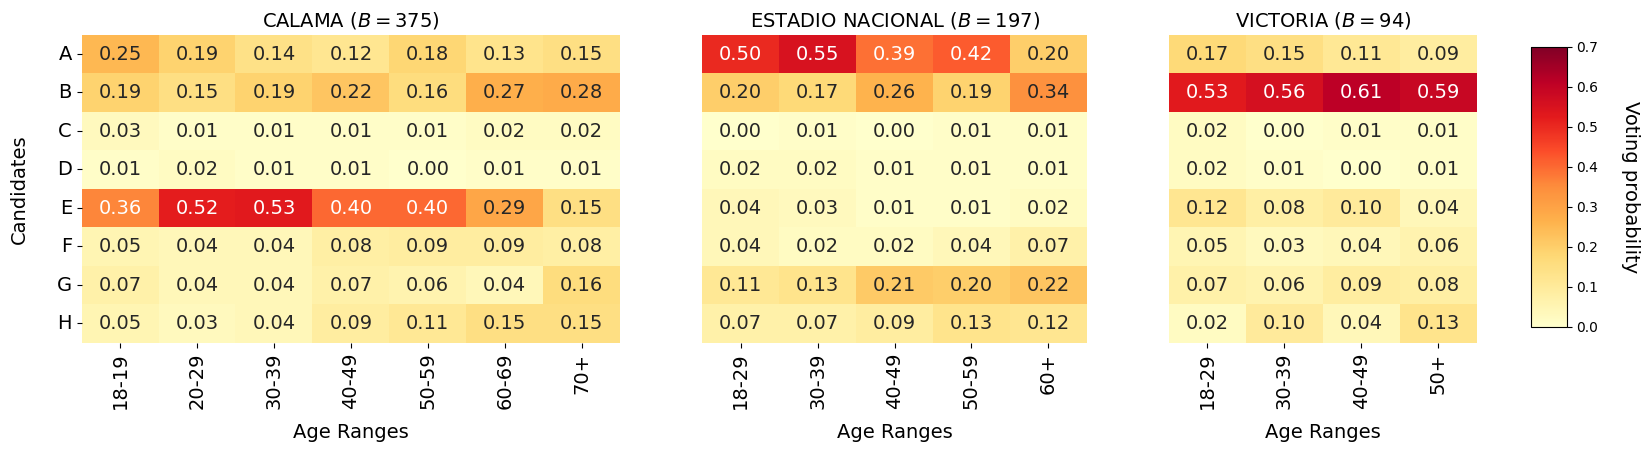

In [62]:


# CANDIDATOS pickle read
with open(f'{election_name}/{output_folder}/CANDIDATOS.pickle', 'rb') as handle:
    CANDIDATOS = np.array(pickle.load(handle))
# order_candidatos = [0,1,2,3,4,6,7,5]
order_candidatos = [2,3,5,0,1,4,6,7]
# LABEL_CANDIDATOS = ['Eduardo Artés', 'Franco Parisi', 'Gabriel Boric', 'José A. Kast',
#                     'Marco E.-Ominami', 'Sebastián Sichel', 'Yasna Provoste', 'Null/Blank']

print(CANDIDATOS[order_candidatos])

LABEL_CANDIDATOS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# LABEL_CANDIDATOS = CANDIDATOS[order_candidatos]
# # change NULO BLANCO for NULL/BLANK
# LABEL_CANDIDATOS = np.where(LABEL_CANDIDATOS == 'NULO BLANCO', 'NULL/BLANK', LABEL_CANDIDATOS)
# # change MARCO ENRIQUEZ-OMINAMI for MARCO E.-OMINAMI
# LABEL_CANDIDATOS = np.where(LABEL_CANDIDATOS == 'MARCO ENRIQUEZ-OMINAMI', 'MARCO E.-OMINAMI', LABEL_CANDIDATOS)
# # change JOSE ANTONIO KAST for JOSE A. KAST
# LABEL_CANDIDATOS = np.where(LABEL_CANDIDATOS == 'JOSE ANTONIO KAST', 'JOSÉ A. KAST', LABEL_CANDIDATOS)
# # change FRANCO ALDO PARISI for FRANCO PARISI
# LABEL_CANDIDATOS = np.where(LABEL_CANDIDATOS == 'FRANCO ALDO PARISI', 'FRANCO PARISI', LABEL_CANDIDATOS)
# # label candidatos as title
# LABEL_CANDIDATOS = [candidato.title() for candidato in LABEL_CANDIDATOS]


# circs = ['CALAMA', 'MAIPU', 'VILLARRICA']
circs = ['CALAMA', 'ESTADIO NACIONAL', 'VICTORIA']
regiones = []
mesas = []
prob_list = []
for circ in circs:
    region = df_pais[df_pais['CIRCUNSCRIPCION ELECTORAL'] == circ]['REGION'].iloc[0]
    regiones.append(region)
    mesas.append(df_pais[df_pais['CIRCUNSCRIPCION ELECTORAL'] == circ]['NUM MESAS'].iloc[0])
    probs = pd.read_csv(f'{election_name}/{output_folder}/{region}/{circ}/P_{circ}.csv', index_col=0)
    df_probs = probs.T
    # multiply by 100
    df_probs = df_probs 
    # round
    df_probs = df_probs.round(2)
    prob_list.append(df_probs)


fig, ax = plt.subplots(1, 3, figsize = (18,4), sharex=False, 
                       sharey=True, width_ratios=[prob_list[0].shape[1], prob_list[1].shape[1], prob_list[2].shape[1]])



for ix, df_probs in enumerate(prob_list):
    # CHANGE NAME OF NULO BLANCO TO NULO/BLANCO
    df_probs = df_probs.rename(index={'NULO BLANCO': 'NULL/BLANK'})
    ax[ix].set_title(f'{circs[ix]} ($B={mesas[ix]}$)', fontsize = 14)
    sns_heatmap = sns.heatmap(df_probs.iloc[order_candidatos], ax=ax[ix], cmap='YlOrRd', cbar=False, vmin = 0, vmax = 0.7,
                    annot = True, annot_kws={"size": 14}, fmt = '.2f')
    ax[0].set_ylabel('Candidates', fontsize = 14, labelpad=20)

    # # add a dot before the number in annot
    # for text in ax[ix].texts:
    #     add_0 = len(text.get_text()) == 1
    #     text.set_text('.'+'0'*add_0+text.get_text())


    # tick labels
    ax[ix].set_yticklabels(LABEL_CANDIDATOS)
    # ticks fontsize
    ax[ix].tick_params(axis='both', which='major', labelsize=14)
    # xlabel
    ax[ix].set_xlabel('Age Ranges', fontsize = 14, labelpad=10)

    # rotate x ticks
    ax[ix].tick_params(axis='x', rotation=90)
    # axis name
    # if ix == 0:
    # #     ax[ix].set_ylabel('Candidates', fontsize = 14)
    if ix >0:
    #     # don't show tick
        ax[ix].tick_params(axis='y', which='both', length=0)
    # ax[ix].set_xlabel('Age Ranges', fontsize = 14)


# Creating a single colorbar for all subplots
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust the position of the cbar accordingly
colorbar = fig.colorbar(sns_heatmap.collections[0], cax=cbar_ax)
# label for colorbar
colorbar.set_label('Voting probability', rotation = -90, fontsize = 14, labelpad=30)

# save fig as probability_results in images/elections directory
plt.savefig(f'images/probability_results.pdf', bbox_inches='tight')



# PUENTE ALTO
# PROVIDENCIA
# ÑUÑOA
# MAIPU
# VALPARAISO
# NORTE
# ARAUCANIA

# Mesas

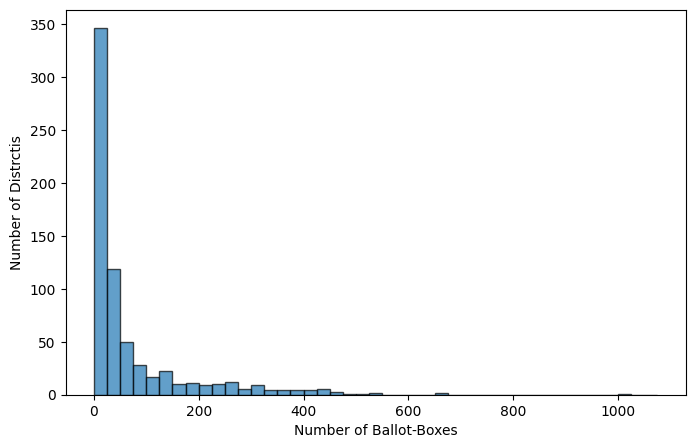

In [7]:
df_mesas = df_pais.copy()
df_mesas = df_mesas.drop_duplicates(subset=['CIRCUNSCRIPCION ELECTORAL'])
df_mesas = df_mesas.groupby('NUM MESAS').count()[['LOCAL']]
df_mesas = df_mesas.reset_index()
df_mesas.rename(columns={'LOCAL': 'COUNT'}, inplace=True)  # Rename the 'LOCAL' column to 'COUNT'

# truncate those with more than 700 to 700
# df_mesas.loc[df_mesas['NUM MESAS'] > 500, 'NUM MESAS'] = 510

# bins = [0, 25, 50, 100, 200, 300, 400, 500,600,700,800,900,1000,1050]
# bins = [0, 10 ,20,30,40,50,60,70,80,90,100,
#         120,140,160,180,200,
#         250,300,350,400,450,500,
#         600,700,800,900,1000,1050]
bins = np.arange(0,1100,25).tolist()

plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.hist(df_mesas['NUM MESAS'], bins=bins, edgecolor='k', alpha=0.7,
         weights=df_mesas['COUNT'])  # Plot the 'COUNT' column

plt.grid(False)
# plt.xticks(np.arange(0, df_mesas['COUNT'].max() + 100, 100))
plt.xlabel('Number of Ballot-Boxes')
plt.ylabel('Number of Distrctis')  # Label the y-axis as 'Frequency' or 'Count', as desired
# change last xtick to 700+
# plt.xticks(np.arange(0, 600, 100).tolist(), [str(i) for i in np.arange(0, 500, 100).tolist()] + ['500+'])
plt.show()

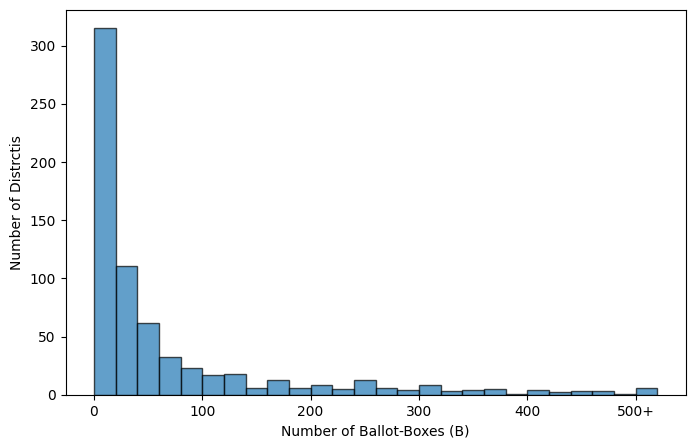

In [8]:
df_mesas = df_pais.copy()
df_mesas = df_mesas.drop_duplicates(subset=['CIRCUNSCRIPCION ELECTORAL'])
df_mesas = df_mesas.groupby('NUM MESAS').count()[['LOCAL']]
df_mesas = df_mesas.reset_index()
df_mesas.rename(columns={'LOCAL': 'COUNT'}, inplace=True)  # Rename the 'LOCAL' column to 'COUNT'

# truncate those with more than 700 to 700
df_mesas.loc[df_mesas['NUM MESAS'] > 500, 'NUM MESAS'] = 510

# bins every 20
bins = np.arange(0, 530, 20).tolist()


plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.hist(df_mesas['NUM MESAS'], bins= bins, edgecolor='k', alpha=0.7,
         weights=df_mesas['COUNT'])  # Plot the 'COUNT' column

plt.grid(False)
# plt.xticks(np.arange(0, df_mesas['COUNT'].max() + 100, 100))
plt.xlabel('Number of Ballot-Boxes (B)')
plt.ylabel('Number of Distrctis')  # Label the y-axis as 'Frequency' or 'Count', as desired
# change last xtick to 700+
plt.xticks(np.arange(0, 600, 100).tolist(), [str(i) for i in np.arange(0, 500, 100).tolist()] + ['500+'])

# save fig as ballotboxes
plt.savefig(f'images/elections/ballotboxes.pdf')

plt.show()

# Group Stats


In [9]:
a = {'a': 1, 'b': 2}

# check if a key is in a dictionary
1 in a

False

In [10]:
circs = df_pais[['REGION', 'CIRCUNSCRIPCION ELECTORAL']].drop_duplicates().to_numpy()
# count mesas for every circ
df_circs = df_pais.groupby(['REGION', 'CIRCUNSCRIPCION ELECTORAL']).count()[['MESA']]
# reset index
df_circs = df_circs.reset_index()
df_circs['GRUPOS'] = -1

age_groups = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_group_count = np.zeros(len(age_groups), dtype=int)

group_count_dict = {}

for region, circ in circs:
    # READ GRUPOS pickle
    # with open(f'{election_name}/{output_folder}/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
    #     GRUPOS_CIRC = pickle.load(handle)
    with open(f'{election_name}/output/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
        GRUPOS_CIRC = pickle.load(handle)
    stripped_GRUPOS_CIRC = [g.strip() for g in GRUPOS_CIRC]
    
    for ix, g in enumerate(age_groups):
        if g in stripped_GRUPOS_CIRC:
            age_group_count[ix] += 1

    for group in stripped_GRUPOS_CIRC:
        # check if it's a key in the dictionary, if not add is as a key
        if group not in group_count_dict:
            group_count_dict[group] = 0
        # increment count
        group_count_dict[group] += 1

    # count groups
    df_circs.loc[(df_circs['REGION'] == region) & (df_circs['CIRCUNSCRIPCION ELECTORAL'] == circ), 'GRUPOS'] = len(GRUPOS_CIRC)

# if MESA == 1, then GRUPOS = 0
df_circs.loc[df_circs['MESA'] == 1, 'GRUPOS'] = 1

# save dictonary as JSON file in 2021_11_Presidencial/output
with open(f'{election_name}/{output_folder}/group_count_dict.json', 'w') as fp:
    json.dump(group_count_dict, fp)


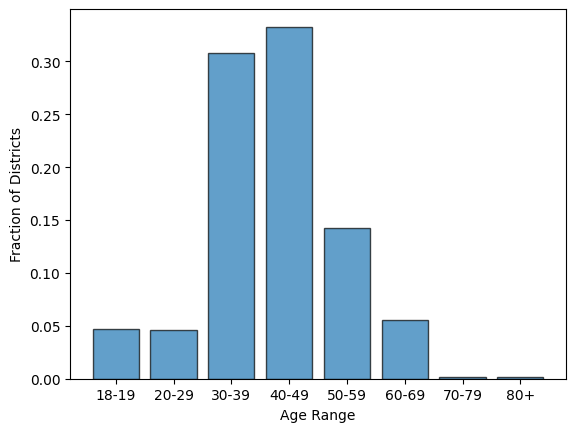

In [11]:
age_group_proportion = age_group_count / len(circs)

# plot barplot, age_group_proportion vs age_groups
fig, ax = plt.subplots(1, 1)
ax.bar(age_groups, age_group_proportion,  
        edgecolor='k', alpha = 0.7)

# axis name
ax.set_ylabel('Fraction of Districts')
ax.set_xlabel('Age Range')
# save fig in images/elections directory
plt.savefig(f'images/elections/single_groups.pdf')

In [12]:
group_number = df_circs.groupby(['GRUPOS']).count()[['MESA']]

group_number = group_number.reset_index()

group_number['proportion'] = np.round(group_number['MESA'] / group_number['MESA'].sum() * 100, 1)

group_number['%'] = group_number['proportion'].astype(str) + '%'


In [13]:
# # list of 7 python colors
# 
# # LIST OF THE SAME 7 COLORS IN RGB
# colors_rgb = [(1,0,0), (0,0,1), (0,1,0), (1,1,0), (1,0,1), (1,0.5,0), (1,0.75,0.8)]

# # BOXPLOT OVER GROUPS AND B
# fig, axs = plt.subplots( figsize = (10,5))
# # wpace subfigs

# subfigs = fig.subfigures(nrows = 1, ncols = 2, width_ratios = [4,1],
#                         wspace = 0) 

# axs = subfigs[0].subplots(nrows=1, ncols=1)

# sns.boxplot(data = df_circs[['GRUPOS', 'MESA']].astype(int), 
#             x = 'GRUPOS', y = 'MESA', palette = colors,
#             ax = axs)
# # axs.boxplot(df_circs[['GRUPOS', 'MESA']].astype(int))
# # namer of axis
# axs.set_ylabel('Number of ballot-boxes (B)')
# axs.set_xlabel('Number of Aggregated Groups (A)')


# axs_2 = subfigs[1].subplots(nrows=2, ncols=1)
# # subfig title
# subfigs[1].suptitle('% Districts', fontsize = 12)

# axs_2[0].pie(group_number['MESA'].to_list(), labels = group_number['%'].to_list() , colors = colors)

# sns.scatterplot(data = group_number, x='MESA', y = '%',
#                         hue = 'GRUPOS', palette = colors, ax = axs_2[1], s = 0)
# axs_2[1].set_frame_on(False)
# axs_2[1].xaxis.set_visible(False)
# axs_2[1].yaxis.set_visible(False)
# # set limits not visible
# axs_2[1].legend(loc = 'center', title = 'G')

# # tight layout
# # fig.tight_layout(

# PORCENTAJE TORTA

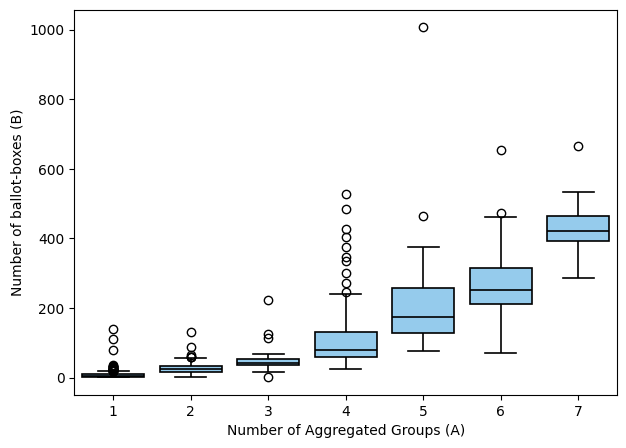

In [32]:
color_groups = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
# BOXPLOT OVER GROUPS AND B
fig, axs = plt.subplots(figsize = (7,5))
# wpace subfigs

sns.boxplot(data = df_circs[['GRUPOS', 'MESA']].astype(int), 
            x = 'GRUPOS', y = 'MESA', color = 'lightskyblue',
            ax = axs, linewidth=1.2, linecolor='black')
# axs.boxplot(df_circs[['GRUPOS', 'MESA']].astype(int))
# namer of axis
axs.set_ylabel('Number of ballot-boxes (B)')
axs.set_xlabel('Number of Aggregated Groups (A)')



# save fig in images/elections directory
plt.savefig(f'images/elections/boxplot_groups.pdf', bbox_inches='tight')

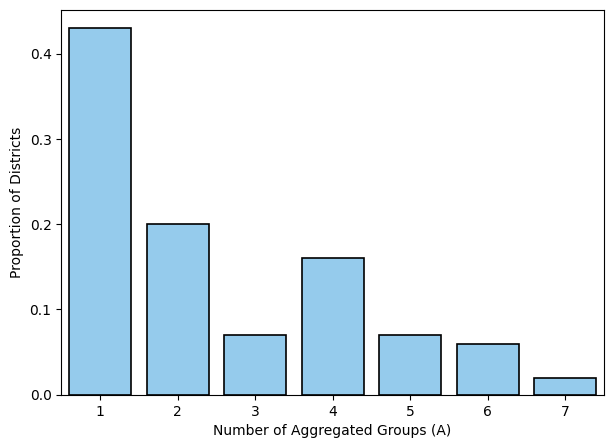

In [35]:
group_number['proportion_'] = np.round(group_number['proportion'] / 100, 2)
# plot barplot, age_group_proportion vs age_groups
fig, ax = plt.subplots(1, 1, figsize = (7,5))
sns.barplot(data = group_number, x = 'GRUPOS', y = 'proportion_', 
            edgecolor='black', linewidth=1.2, color = 'lightskyblue')
# axis name
ax.set_ylabel('Proportion of Districts')
ax.set_xlabel('Number of Aggregated Groups (A)')
# save fig in images/elections directory
plt.savefig(f'images/elections/barplot_groups.pdf', bbox_inches='tight')

## Presentación

In [16]:
circs = df_pais[['REGION', 'CIRCUNSCRIPCION ELECTORAL']].drop_duplicates().to_numpy()
# count mesas for every circ
df_circs = df_pais.groupby(['REGION', 'CIRCUNSCRIPCION ELECTORAL']).count()[['MESA']]
# reset index
df_circs = df_circs.reset_index()
df_circs['GRUPOS'] = -1

age_groups = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_group_count = np.zeros(len(age_groups), dtype=int)

for region, circ in circs:
    # READ GRUPOS pickle
    # with open(f'{election_name}/{output_folder}/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
    #     GRUPOS_CIRC = pickle.load(handle)
    with open(f'{election_name}/output/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
        GRUPOS_CIRC = pickle.load(handle)
    stripped_GRUPOS_CIRC = [g.strip() for g in GRUPOS_CIRC]
    for ix, g in enumerate(age_groups):
        if g in stripped_GRUPOS_CIRC:
            age_group_count[ix] += 1

    # count groups
    df_circs.loc[(df_circs['REGION'] == region) & (df_circs['CIRCUNSCRIPCION ELECTORAL'] == circ), 'GRUPOS'] = len(GRUPOS_CIRC)

# if MESA == 1, then GRUPOS = 0
df_circs.loc[df_circs['MESA'] == 1, 'GRUPOS'] = 1

group_number = df_circs.groupby(['GRUPOS']).count()[['MESA']]

group_number = group_number.reset_index()

group_number['proportion'] = np.round(group_number['MESA'] / group_number['MESA'].sum() * 100, 1)

group_number['%'] = group_number['proportion'].astype(str) + '%'

C:\Users\pablo\AppData\Local\Temp\ipykernel_18280\2595678860.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_circs[['GRUPOS', 'MESA']].astype(int),
C:\Users\pablo\AppData\Local\Temp\ipykernel_18280\2595678860.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = group_number, x = 'GRUPOS', y = 'proportion_', palette = color_groups,


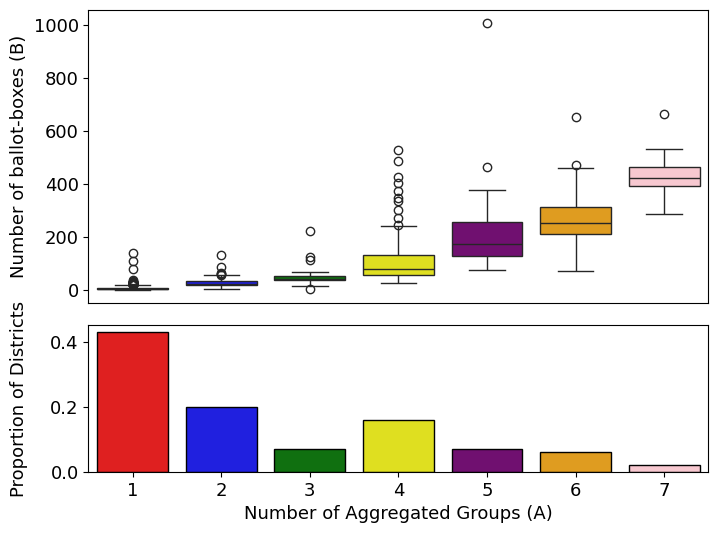

In [17]:
color_groups = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
# BOXPLOT OVER GROUPS AND B
fig, axs = plt.subplots(2,1,figsize = (8,6), height_ratios=[2, 1], sharex=True)
# wpace subfigs

sns.boxplot(data = df_circs[['GRUPOS', 'MESA']].astype(int), 
            x = 'GRUPOS', y = 'MESA', palette = color_groups,
            ax = axs[0])
# axs.boxplot(df_circs[['GRUPOS', 'MESA']].astype(int))
# namer of axis
axs[0].set_ylabel('Number of ballot-boxes (B)', fontsize = 13)
# no xlabel and no ticks
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', which='both', length=0)

# save fig in images/elections directory
# plt.savefig(f'images/elections/boxplot_groups.pdf', bbox_inches='tight')

group_number['proportion_'] = np.round(group_number['proportion'] / 100, 2)
# plot barplot, age_group_proportion vs age_groups


sns.barplot(data = group_number, x = 'GRUPOS', y = 'proportion_', palette = color_groups,
            edgecolor='k', ax = axs[1])
# axis name
axs[1].set_ylabel('Proportion of Districts', fontsize = 13)
axs[1].set_xlabel('Number of Aggregated Groups (A)', fontsize = 13)

#hspace
plt.subplots_adjust(hspace=0.1)

#ticks fontsize
axs[0].tick_params(axis='both', which='major', labelsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)

#match ylabels spacing
fig.align_ylabels(axs[:])

# save fig in images/elections directory
plt.savefig(f'images/group_stats.pdf', bbox_inches='tight')

# Heatmaps


In [18]:
with open(f'{election_name}/output/CANDIDATOS.pickle', 'rb') as handle:
    CANDIDATOS = np.array(pickle.load(handle))
order_candidatos = [0,1,2,3,4,6,7,5]

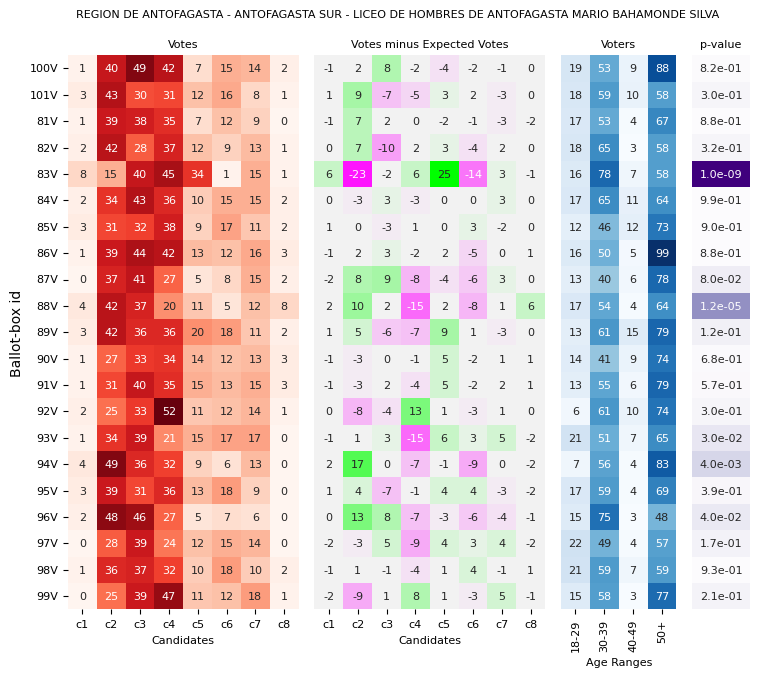

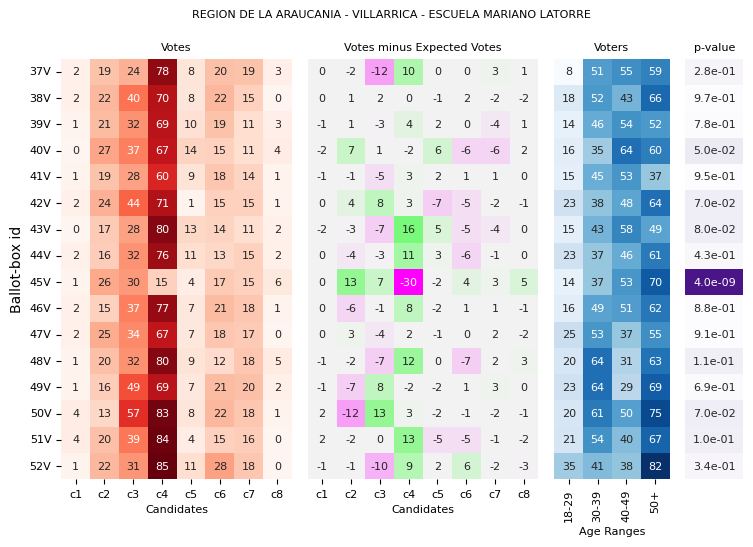

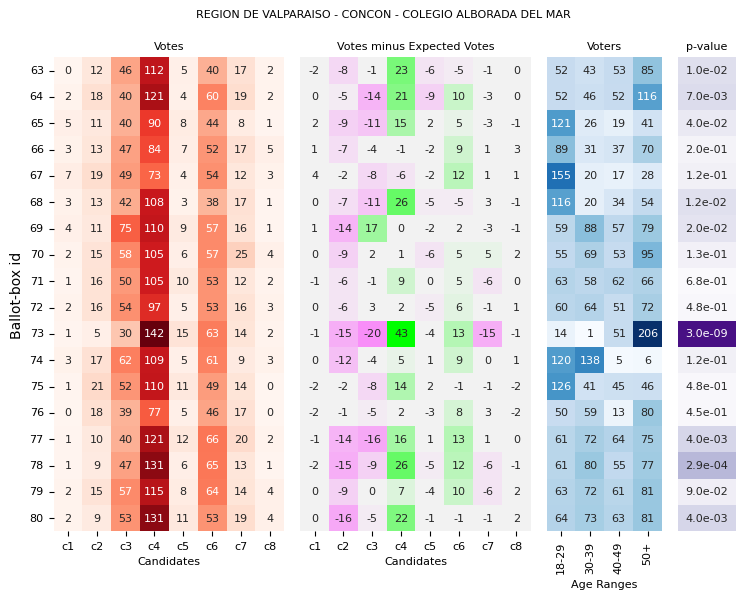

In [20]:
max_pval = log_pvalue_precision
for region, circ, local in low_p[:3]:
    with open(f'{election_name}/{output_folder}/CANDIDATOS.pickle', 'rb') as handle:
        CANDIDATOS = np.array(pickle.load(handle))
    with open(f'{election_name}/{output_folder}/GRUPOS.pickle', 'rb') as handle:
        GRUPOS = pickle.load(handle)


    map_dif = sns.diverging_palette(-50, 130, s=500, l=75, sep = 25, center='light', as_cmap=True)

    df_region = pd.read_csv(f'{election_name}/{output_folder}/{region}/{region}.csv')
    df_region_pval = df_region[['MESA', 'CIRCUNSCRIPCION ELECTORAL', 'P-VALOR']].copy()

    df_circ = pd.read_csv(f'{election_name}/output/{region}/{circ}/{circ}.csv')
    prob_circ = pd.read_csv(f'{election_name}/{output_folder}/{region}/{circ}/P_{circ}.csv')

    with open(f'{election_name}/output/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
        grupos_local = pickle.load(handle)

    df_local = df_circ[df_circ['LOCAL'] == local].copy()
    # erase P-VALUE column
    df_local = df_local.drop(columns = ['P-VALOR'])
    #merge
    df_local = df_local.merge(df_region_pval, on = ['MESA', 'CIRCUNSCRIPCION ELECTORAL'], how ='inner')
    dif_CANDIDATOS = np.array([f'DIF_{c}' for c in CANDIDATOS])

    df_local.loc[df_local['P-VALOR'] == 0, 'P-VALOR'] = 10**(max_pval-1)
    zero_text = f'1.0e{max_pval-1}' # valor del color que tomaran los p-valores 0 

    w_1 = 0.4
    w_2 = 0.3
    fig, ax = plt.subplots(1, 4, sharey=True, figsize=(w_1*(2*len(CANDIDATOS) + len(grupos_local) + 2),w_2*(2+len(df_local))), 
                            width_ratios=[len(CANDIDATOS), len(CANDIDATOS), len(grupos_local), 2])

    fig.suptitle(f'REGION {region} - {circ} - {local}', fontsize=8)
    # set space from title
    plt.subplots_adjust(top=len(df_local)/(2 + len(df_local)))   

    # set 'MESA' as index
    df_local = df_local.set_index('MESA')

    # ax title
    ax[0].set_title('Votes', fontsize = 8)
    # heatmap of candidatos
    sns.heatmap(df_local[CANDIDATOS[order_candidatos]].astype(int), cmap = 'Reds', cbar = False, fmt = 'g',
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[0],
                xticklabels = [f'c{i}' for i in range(1, len(CANDIDATOS)+1)])
    # rotate y ticks
    ax[0].tick_params(axis='y', rotation=0, labelsize = 8)
    # y axis label
    ax[0].set_ylabel('Ballot-box id')

    
    # x axis label
    ax[0].xaxis.set_label_position('bottom')
    ax[0].set_xlabel('Candidates', fontsize = 8)


    # ax title
    ax[1].set_title('Votes minus Expected Votes', fontsize = 8)
    sns.heatmap(df_local[dif_CANDIDATOS[order_candidatos]].astype(int), cmap = map_dif, cbar = False, fmt ='g',
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[1], center = 0,
                xticklabels = [f'c{i}' for i in range(1, len(CANDIDATOS)+1)])
    # set xlabel on bottom
    ax[1].xaxis.set_label_position('bottom')
    ax[1].set_xlabel('Candidates', fontsize = 8)



    # ax title
    ax[2].set_title('Voters', fontsize = 8)
    sns.heatmap(df_local[grupos_local].astype(int), cmap = 'Blues', cbar = False, fmt = 'g', 
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[2])
    ax[2].xaxis.set_label_position('bottom')
    ax[2].set_xlabel('Age Ranges', fontsize = 8)


    # ax title
    ax[3].set_title('p-value', fontsize = 8)
    # pvalue
    sns.heatmap(df_local[['P-VALOR']], cmap = 'Purples_r', cbar = False,
                annot = True, fmt = '.1e', annot_kws = {'fontsize': 8}, ax = ax[3],
                xticklabels = False, norm = colors.LogNorm(vmin=10**(threshold-1), vmax=1))
    # ax[3].xaxis.set_label_position('top')
    # ax[3].set_xlabel('p-value', fontsize = 8)   

    for text in ax[3].texts:
        if text.get_text() == zero_text:
            text.set_text(f'<1.0e0{-max_pval}')
        # else:
        #     text.set_text(text.get_text().replace('.', ','))

    # only show yticks in axis 0
    for ix in range(1, 4):
        ax[ix].tick_params(left = False)
        # dont show y label
        ax[ix].set_ylabel('')

    # set fontsize for ticks
    for ix in range(4):
        ax[ix].tick_params(axis='both', which='major', labelsize=8)
        


    plt.subplots_adjust(wspace=0.1)
    local_directory = local.replace(':','')
    plt.savefig(f'images/elections/heatmaps/{local_directory}.pdf')
    plt.show()

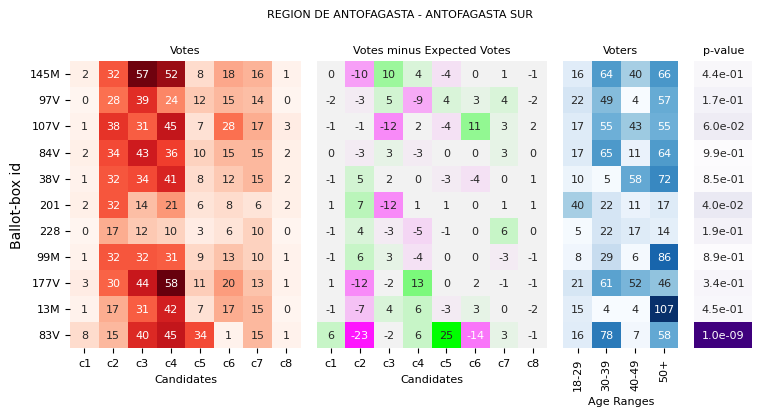

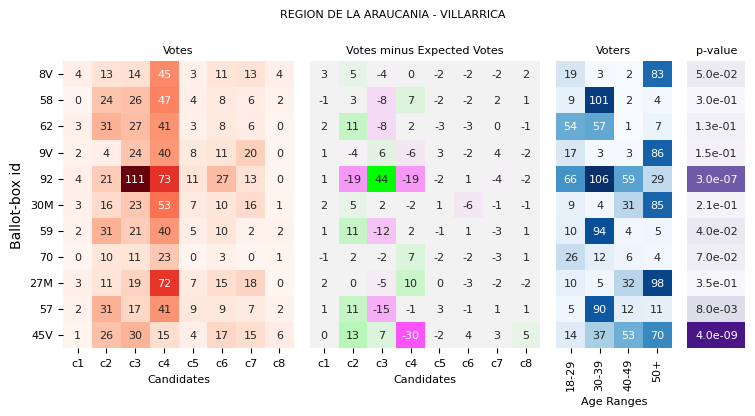

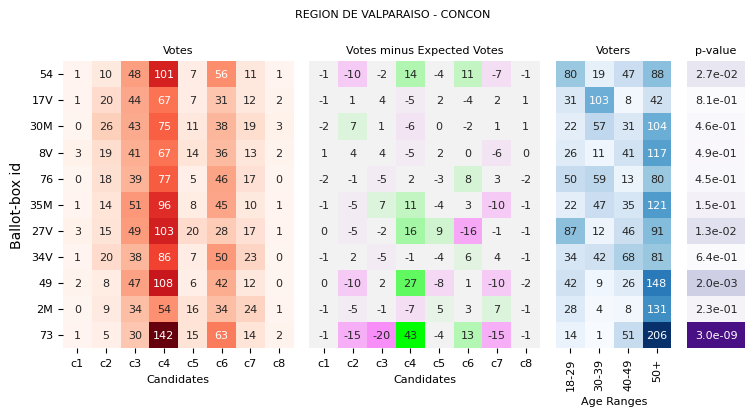

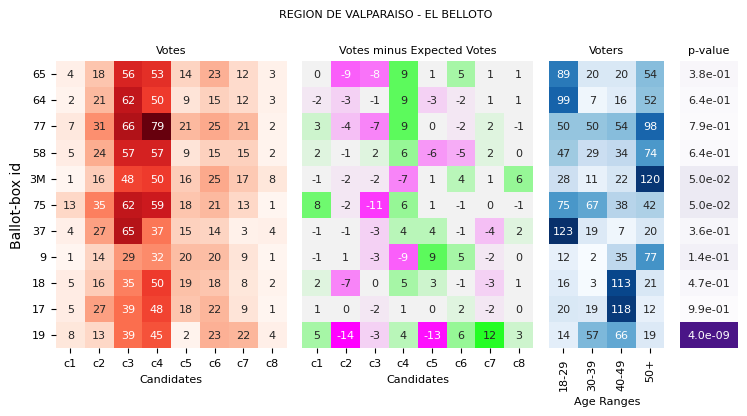

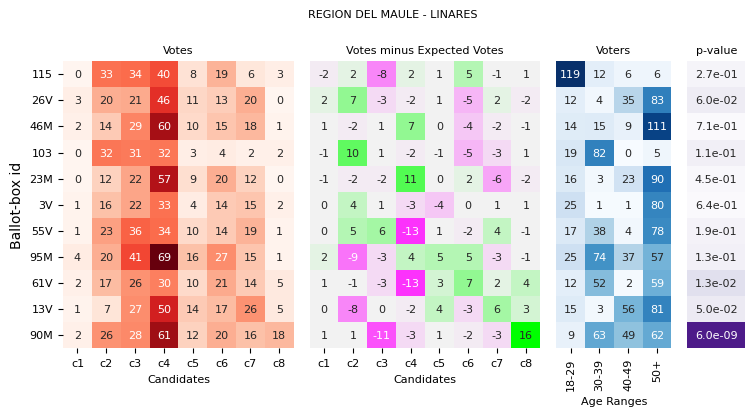

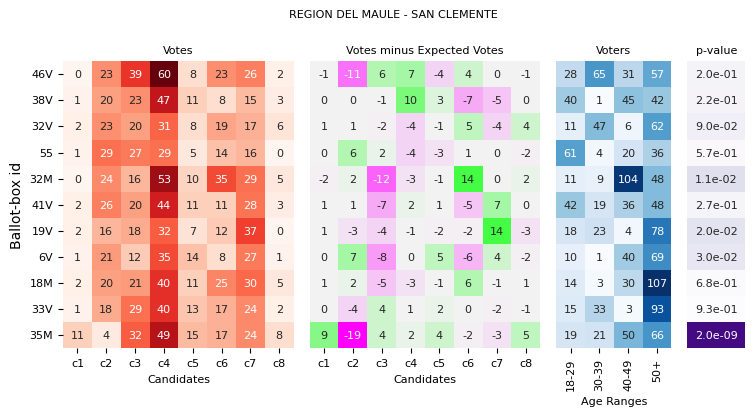

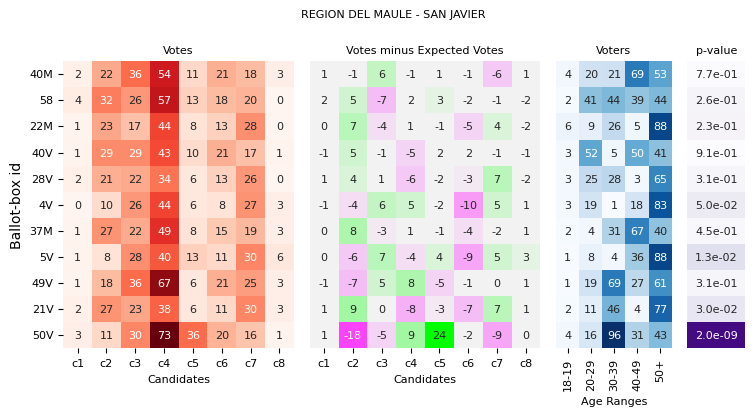

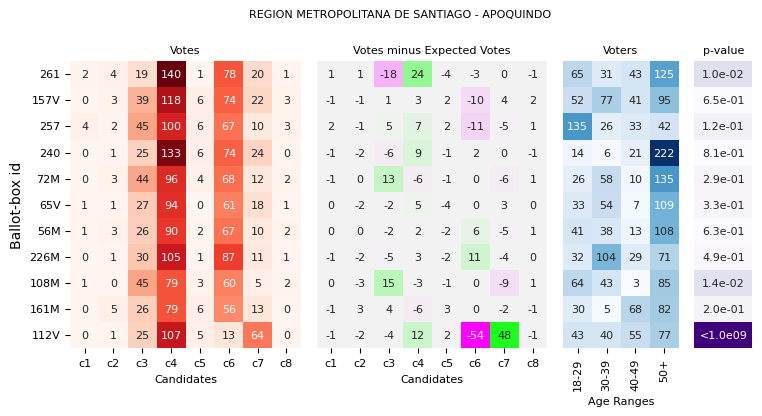

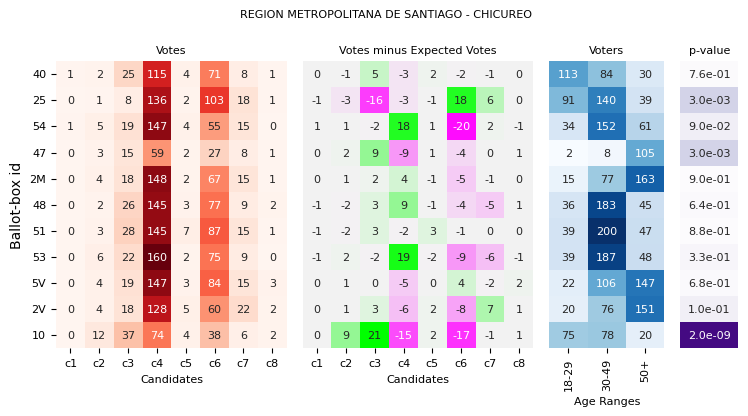

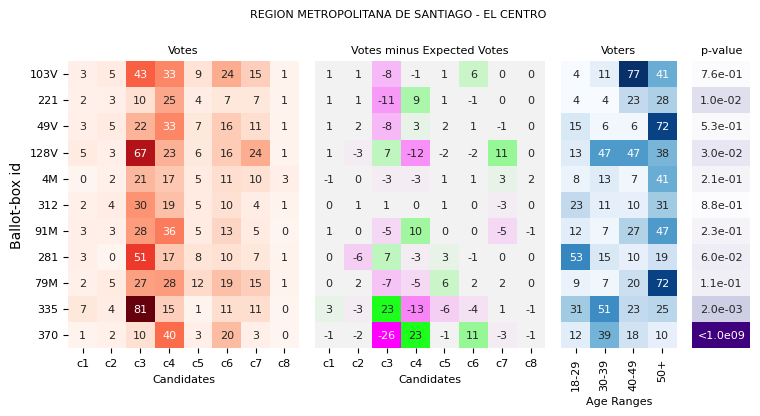

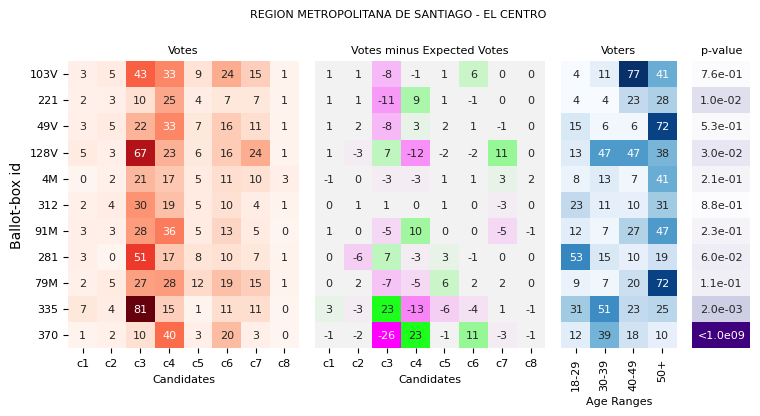

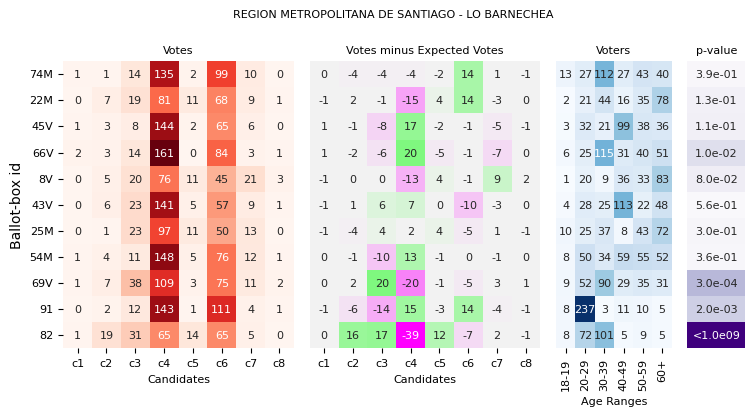

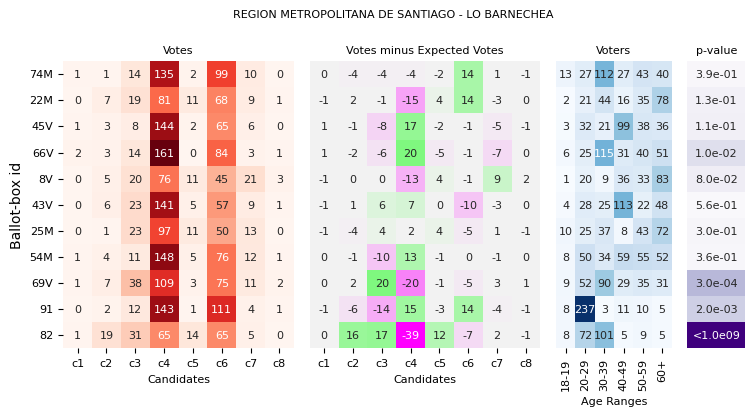

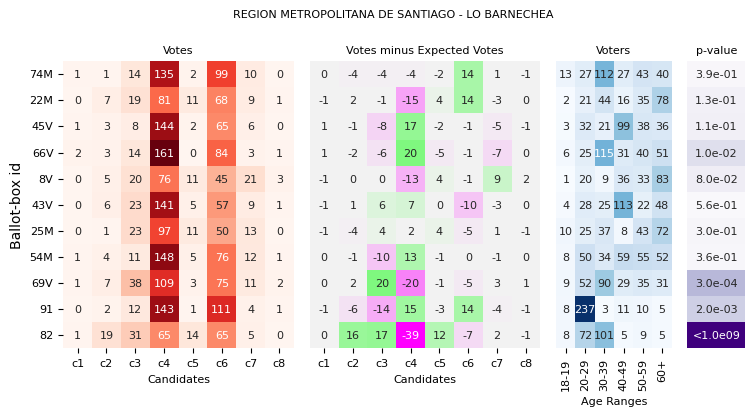

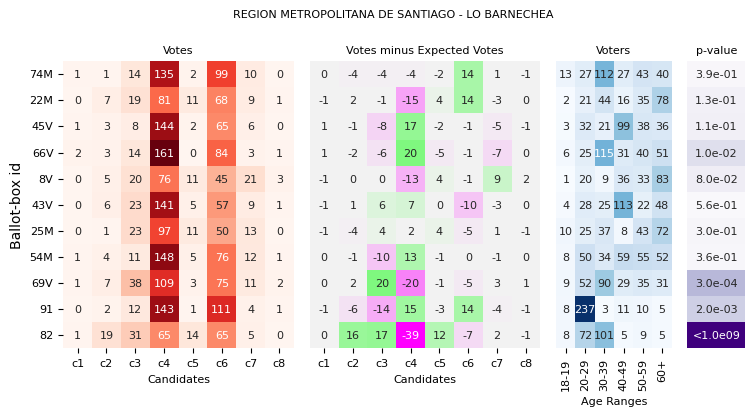

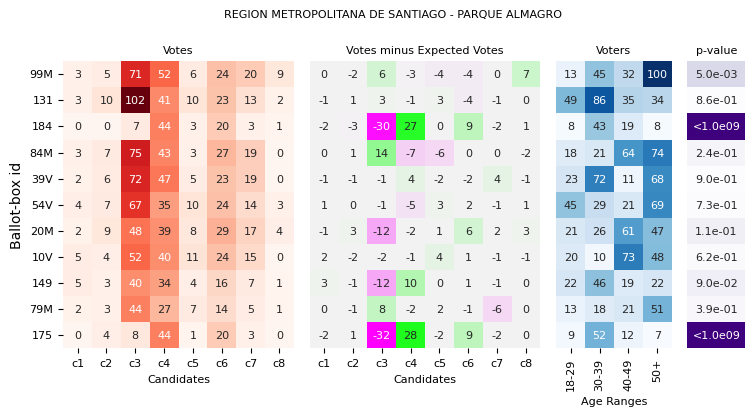

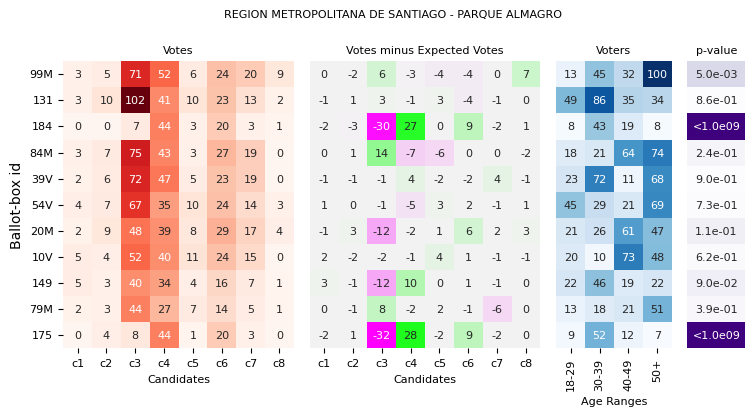

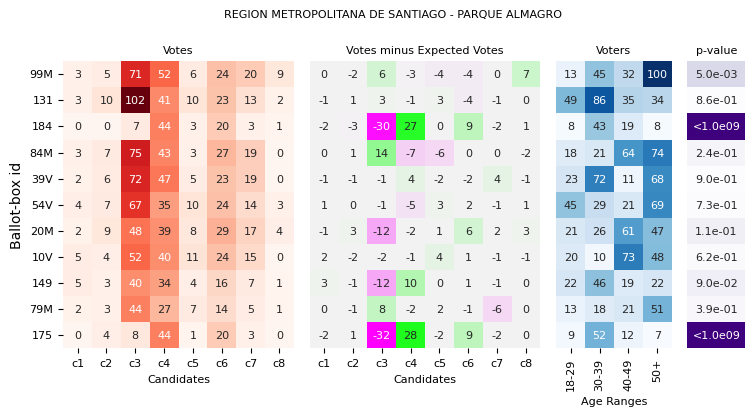

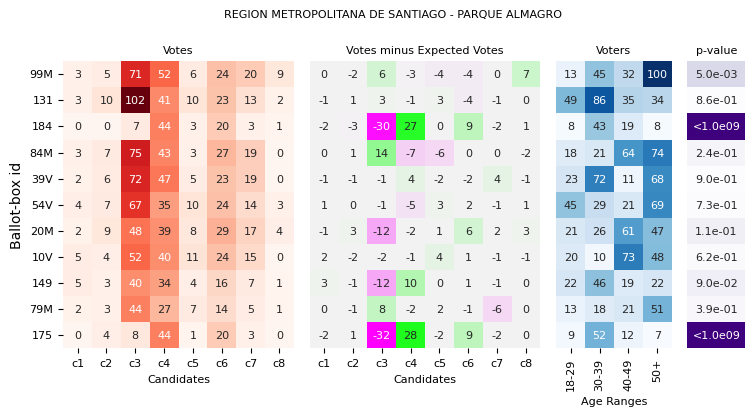

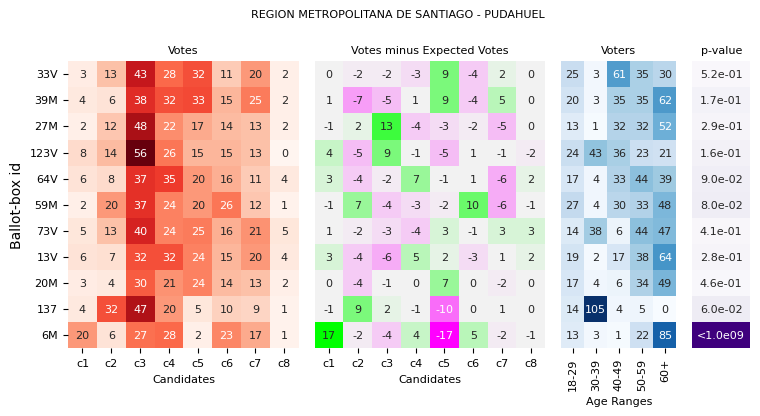

In [54]:
max_pval = log_pvalue_precision
for region, circ, _ in low_p:
    with open(f'{election_name}/{output_folder}/CANDIDATOS.pickle', 'rb') as handle:
        CANDIDATOS = np.array(pickle.load(handle))
    with open(f'{election_name}/{output_folder}/GRUPOS.pickle', 'rb') as handle:
        GRUPOS = pickle.load(handle)


    map_dif = sns.diverging_palette(-50, 130, s=500, l=75, sep = 25, center='light', as_cmap=True)

    df_region = pd.read_csv(f'{election_name}/{output_folder}/{region}/{region}.csv')
    df_region_pval = df_region[['MESA', 'CIRCUNSCRIPCION ELECTORAL', 'P-VALOR']].copy()

    df_circ = pd.read_csv(f'{election_name}/output/{region}/{circ}/{circ}.csv')
    prob_circ = pd.read_csv(f'{election_name}/{output_folder}/{region}/{circ}/P_{circ}.csv')

    with open(f'{election_name}/output/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
        grupos = pickle.load(handle)


    # from df_region_pval, find the smalles P-VALOR from CIRCUNSCRIPCION ELECTORAL
    df_circ_pval = df_region_pval[df_region_pval['CIRCUNSCRIPCION ELECTORAL'] == circ]
    mesa_smallest = df_circ_pval[df_circ_pval['P-VALOR'] == df_circ_pval['P-VALOR'].min()].iloc[0]

    # save seed
    seed = 32
    # sample random sample from df_circ
    df_heatmap = df_circ.sample(10, random_state=seed)
    # add mesa with smallest p-value 

    # Assuming 'MESA' is a unique identifier, check if the mesa with the smallest p-value is already in the sample.
    if mesa_smallest['MESA'] not in df_heatmap['MESA'].values:
        df_mesa_smallest = df_circ[df_circ['MESA'] == mesa_smallest['MESA']]
        # If not, append this row to the dataframe.
        df_heatmap = pd.concat([df_heatmap, df_mesa_smallest], ignore_index=True)

    # erase P-VALUE column
    df_heatmap = df_heatmap.drop(columns = ['P-VALOR'])
    #merge
    df_heatmap = df_heatmap.merge(df_region_pval, on = ['MESA', 'CIRCUNSCRIPCION ELECTORAL'], how ='inner')
    dif_CANDIDATOS = np.array([f'DIF_{c}' for c in CANDIDATOS])

    df_heatmap.loc[df_heatmap['P-VALOR'] == 0, 'P-VALOR'] = 10**(max_pval-1)
    zero_text = f'1.0e{max_pval-1}' # valor del color que tomaran los p-valores 0 

    # w parameters for subplots size
    w_1 = 0.4
    w_2 = 0.3
    fig, ax = plt.subplots(1, 4, sharey=True, figsize=(w_1*(2*len(CANDIDATOS) + len(grupos_local) + 2),w_2*(2+len(df_heatmap))), 
                            width_ratios=[len(CANDIDATOS), len(CANDIDATOS), len(grupos_local), 2])

    fig.suptitle(f'REGION {region} - {circ}', fontsize=8)
    # set space from title
    plt.subplots_adjust(top=len(df_heatmap)/(2 + len(df_heatmap)))   

    # set 'MESA' as index
    df_heatmap = df_heatmap.set_index('MESA')


    # ax title
    ax[0].set_title('Votes', fontsize = 8)
    # heatmap of candidatos
    sns.heatmap(df_heatmap[CANDIDATOS[order_candidatos]].astype(int), cmap = 'Reds', cbar = False, fmt = 'g',
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[0],
                xticklabels = [f'c{i}' for i in range(1, len(CANDIDATOS)+1)])
    # rotate y ticks
    ax[0].tick_params(axis='y', rotation=0, labelsize = 8)
    # y axis label
    ax[0].set_ylabel('Ballot-box id')

    
    # x axis label
    ax[0].xaxis.set_label_position('bottom')
    ax[0].set_xlabel('Candidates', fontsize = 8)


    # ax title
    ax[1].set_title('Votes minus Expected Votes', fontsize = 8)
    sns.heatmap(df_heatmap[dif_CANDIDATOS[order_candidatos]].astype(int), cmap = map_dif, cbar = False, fmt ='g',
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[1], center = 0,
                xticklabels = [f'c{i}' for i in range(1, len(CANDIDATOS)+1)])
    # set xlabel on bottom
    ax[1].xaxis.set_label_position('bottom')
    ax[1].set_xlabel('Candidates', fontsize = 8)



    # ax title
    ax[2].set_title('Voters', fontsize = 8)
    sns.heatmap(df_heatmap[grupos].astype(int), cmap = 'Blues', cbar = False, fmt = 'g', 
                annot = True, annot_kws = {'fontsize': 8}, ax = ax[2])
    ax[2].xaxis.set_label_position('bottom')
    ax[2].set_xlabel('Age Ranges', fontsize = 8)


    # ax title
    ax[3].set_title('p-value', fontsize = 8)
    # pvalue
    sns.heatmap(df_heatmap[['P-VALOR']], cmap = 'Purples_r', cbar = False,
                annot = True, fmt = '.1e', annot_kws = {'fontsize': 8}, ax = ax[3],
                xticklabels = False, norm = colors.LogNorm(vmin=10**(threshold-1), vmax=1))
    # ax[3].xaxis.set_label_position('top')
    # ax[3].set_xlabel('p-value', fontsize = 8)   

    for text in ax[3].texts:
        if text.get_text() == zero_text:
            text.set_text(f'<1.0e0{-max_pval}')
        # else:
        #     text.set_text(text.get_text().replace('.', ','))

    # only show yticks in axis 0
    for ix in range(1, 4):
        ax[ix].tick_params(left = False)
        # dont show y label
        ax[ix].set_ylabel('')

    # set fontsize for ticks
    for ix in range(4):
        ax[ix].tick_params(axis='both', which='major', labelsize=8)
        


    plt.subplots_adjust(wspace=0.1)
    local_directory = local.replace(':','')
    plt.savefig(f'images/elections/heatmaps/{circ}-{seed}.pdf')
    plt.show()

In [ ]:
appendix_tex = r''''''
for region, circ, local in low_p:
    local_directory = local.replace(':','')
    appendix_tex += r'''\begin{figure}[H]''' + '\n'
    appendix_tex += r'''\includegraphics[width =\textwidth,height=\textheight,keepaspectratio]{img/election/heatmaps/'''+local_directory+r'''.pdf}''' + '\n'
    appendix_tex += r'''\caption{'''+ f'Results in the polling place of: \\textit' +r'''{''' + local.title()  + r'''}}''' + '\n'
    appendix_tex += r'''\label{''' + local_directory + r'''}''' + '\n'
    appendix_tex += r'''\end{figure}''' + '\n' + '\n'

# save to text
with open(f'images/elections/heatmaps/appendix.txt', 'w') as f:
    f.write(appendix_tex)


## Presentación

In [ ]:
locales = ['COLEGIO FILIPENSE', 'ESCUELA MONSENOR CARLOS OVIEDO', 
           'COLEGIO EXCELSIOR LOCAL: 1', 'LICEO JAVIERA CARRERA LOCAL: 2',
           'ESCUELA GERONIMO LAGOS LISBOA']

In [ ]:
# local = 'COLEGIO D-417 GUARDIAMARINA GUILLERMO ZANARTU IRIGOYEN'
# # find region and circ from local
# region = df_pais[df_pais['LOCAL'] == local]['REGION'].iloc[0]
# circ = df_pais[df_pais['LOCAL'] == local]['CIRCUNSCRIPCION ELECTORAL'].iloc[0]

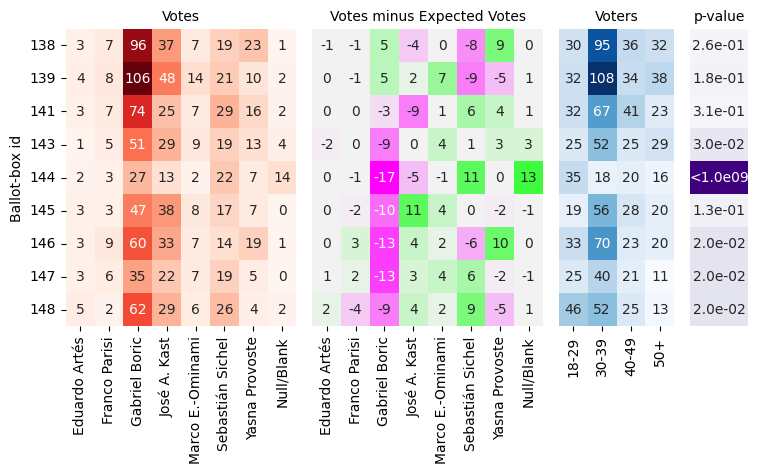

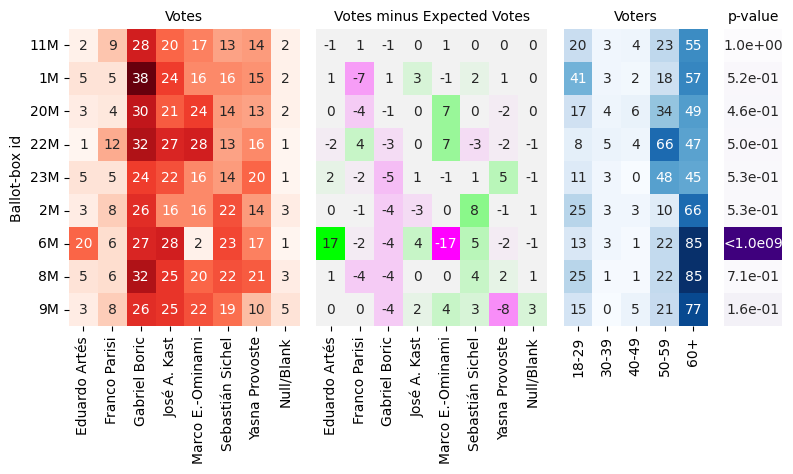

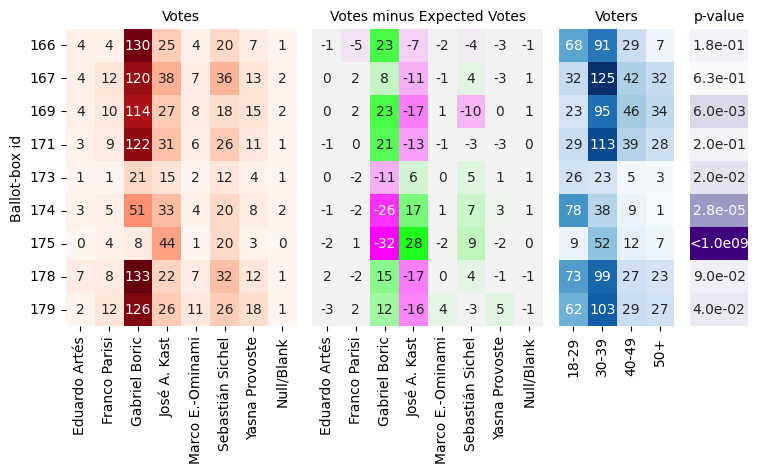

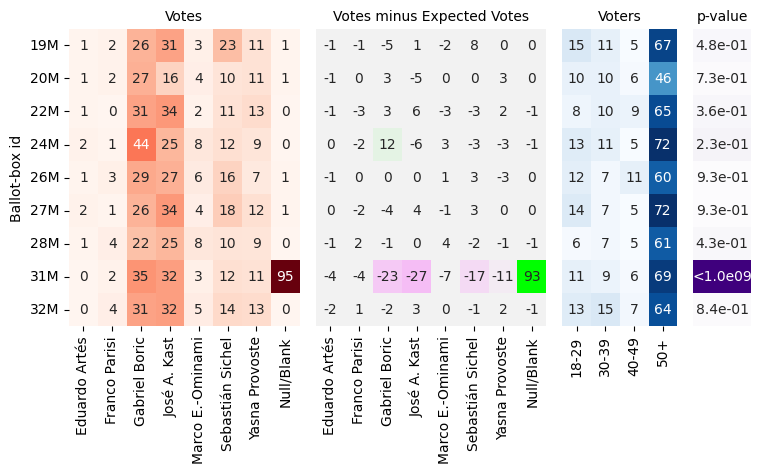

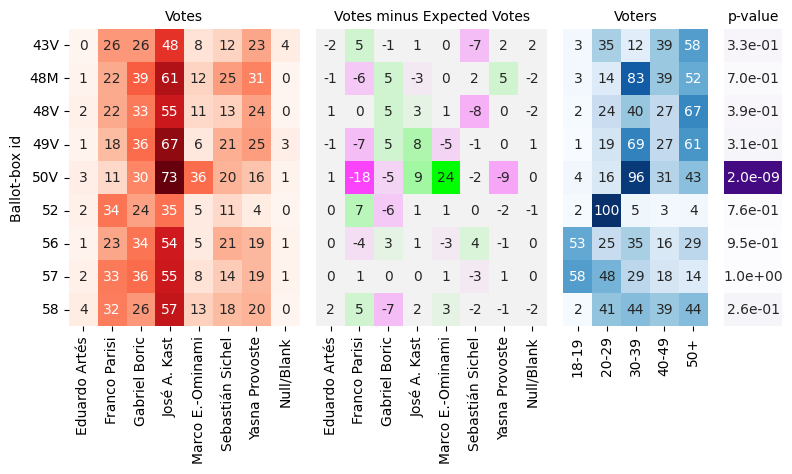

In [ ]:
for local in locales:
    region = df_pais[df_pais['LOCAL'] == local]['REGION'].iloc[0]
    circ = df_pais[df_pais['LOCAL'] == local]['CIRCUNSCRIPCION ELECTORAL'].iloc[0]
    max_pval = log_pvalue_precision
    with open(f'{election_name}/{output_folder}/CANDIDATOS.pickle', 'rb') as handle:
        CANDIDATOS = np.array(pickle.load(handle))
    with open(f'{election_name}/{output_folder}/GRUPOS.pickle', 'rb') as handle:
        GRUPOS = pickle.load(handle)

    LABEL_CANDIDATOS = ['Eduardo Artés', 'Franco Parisi', 'Gabriel Boric', 'José A. Kast',
                        'Marco E.-Ominami', 'Sebastián Sichel', 'Yasna Provoste', 'Null/Blank']

    map_dif = sns.diverging_palette(-50, 130, s=500, l=75, sep = 25, center='light', as_cmap=True)

    df_region = pd.read_csv(f'{election_name}/{output_folder}/{region}/{region}.csv')
    df_region_pval = df_region[['MESA', 'CIRCUNSCRIPCION ELECTORAL', 'P-VALOR']].copy()

    df_circ = pd.read_csv(f'{election_name}/{output_folder}/{region}/{circ}/{circ}.csv')
    prob_circ = pd.read_csv(f'{election_name}/{output_folder}/{region}/{circ}/P_{circ}.csv')

    with open(f'{election_name}/output/{region}/{circ}/GRUPOS.pickle', 'rb') as handle:
        grupos_local = pickle.load(handle)

    df_local = df_circ[df_circ['LOCAL'] == local].copy()
    # erase P-VALUE column
    df_local = df_local.drop(columns = ['P-VALOR'])
    #merge
    df_local = df_local.merge(df_region_pval, on = ['MESA', 'CIRCUNSCRIPCION ELECTORAL'], how ='inner')
    dif_CANDIDATOS = np.array([f'DIF_{c}' for c in CANDIDATOS])

    df_local.loc[df_local['P-VALOR'] == 0, 'P-VALOR'] = 10**(max_pval-1)
    zero_text = f'1.0e{max_pval-1}' # valor del color que tomaran los p-valores 0 

    np.random.seed(5)
    # save the row with the lowest p-value as a different data frame
    df_local_lowest_p = df_local[df_local['P-VALOR'] == df_local['P-VALOR'].min()].copy()

    # sample 7 rows from df_local  
    df_local_sample = df_local.sample(n=9, replace = False, random_state=0)

    # join both data frames and drop duplicates
    df_local = pd.concat([df_local_lowest_p, df_local_sample]).drop_duplicates()

    # order by MESA
    df_local = df_local.sort_values(by=['MESA'])

    w_1 = 0.4
    w_2 = 0.3
    fig, ax = plt.subplots(1, 4, sharey=True, figsize=(w_1*(2*len(CANDIDATOS) + len(grupos_local) + 2),w_2*(5+len(df_local))), 
                            width_ratios=[len(CANDIDATOS), len(CANDIDATOS), len(grupos_local), 2])

    # fig.suptitle(f'REGION {region} - {circ} - {local}', fontsize=8)
    # set space from title
    plt.subplots_adjust(top=len(df_local)/(2 + len(df_local)))   

    # set 'MESA' as index
    df_local = df_local.set_index('MESA')

    # ax title
    ax[0].set_title('Votes', fontsize = 10)
    # heatmap of candidatos
    sns.heatmap(df_local[CANDIDATOS[order_candidatos]].astype(int), cmap = 'Reds', cbar = False, fmt = 'g',
                annot = True, annot_kws = {'fontsize': 10}, ax = ax[0], xticklabels=LABEL_CANDIDATOS)
    # rotate y ticks
    ax[0].tick_params(axis='y', rotation=0, labelsize = 10)
    # y axis label
    ax[0].set_ylabel('Ballot-box id', fontsize = 10)


    # x axis label
    # ax[0].xaxis.set_label_position('bottom')
    # ax[0].set_xlabel('Candidates', fontsize = 8)


    # ax title
    ax[1].set_title('Votes minus Expected Votes', fontsize = 10)
    sns.heatmap(df_local[dif_CANDIDATOS[order_candidatos]].astype(int), cmap = map_dif, cbar = False, fmt ='g',
                annot = True, annot_kws = {'fontsize': 10}, ax = ax[1], center = 0, xticklabels=LABEL_CANDIDATOS)
    # set xlabel on bottom
    # ax[1].xaxis.set_label_position('bottom')
    # ax[1].set_xlabel('Candidates', fontsize = 8)



    # ax title
    ax[2].set_title('Voters', fontsize = 10)
    sns.heatmap(df_local[grupos_local].astype(int), cmap = 'Blues', cbar = False, fmt = 'g', 
                annot = True, annot_kws = {'fontsize': 10}, ax = ax[2])
    ax[2].xaxis.set_label_position('bottom')
    # ax[2].set_xlabel('Age Ranges', fontsize = 8)


    # ax title
    ax[3].set_title('p-value', fontsize = 10)
    # pvalue
    sns.heatmap(df_local[['P-VALOR']], cmap = 'Purples_r', cbar = False,
                annot = True, fmt = '.1e', annot_kws = {'fontsize': 10}, ax = ax[3],
                xticklabels = False, norm = colors.LogNorm(vmin=10**(threshold-1), vmax=1))
    # ax[3].xaxis.set_label_position('top')
    # ax[3].set_xlabel('p-value', fontsize = 8)   

    for text in ax[3].texts:
        if text.get_text() == zero_text:
            text.set_text(f'<1.0e0{-max_pval}')
        # else:
        #     text.set_text(text.get_text().replace('.', ','))

    # only show yticks in axis 0
    for ix in range(1, 4):
        ax[ix].tick_params(left = False)
        # dont show y label
        ax[ix].set_ylabel('')

    # set fontsize for ticks
    for ix in range(4):
        ax[ix].tick_params(axis='both', which='major', labelsize=10)
        

    plt.subplots_adjust(wspace=0.1)
    local_directory = local.replace(':','')
    # save fig so that it looks complete
    # plt.savefig(f'images/elections/heatmaps/.pdf', bbox_inches='tight')
    # replace : for - in local title
    local_title = local.replace(':','-')
    # create directory images/presentacion/heatmaps if it doesn't exist
    import os
    if not os.path.exists('images/presentacion/heatmaps'):
        os.makedirs('images/presentacion/heatmaps')
    plt.savefig(f'images/presentacion/heatmaps/{local_title}.pdf', bbox_inches='tight')
    plt.show()